In [182]:
import numpy as np
import matplotlib.pyplot as plt

In [183]:
class RK_Orbit_Integrator:

    def __init__(self, pos, vel, stepCount, dt = 1, drift = True):
        self.posArr = np.zeros((stepCount, 3))
        self.velArr = np.zeros((stepCount, 3))
        self.posArr[0] = pos
        self.velArr[0] = vel
        self.index = 1
        self.stepCount = stepCount
        self.time = 0 # s since start
        self.dt = dt # s
        self.period = np.zeros(0) # s

        self.mu = 3.986004418e14
        self.Re = 6378.138e3
        if drift:
            self.J2 = 1.08262668e-3
        else:
            self.J2 = 0

    def __magnitude(self, vec):
        return np.sqrt(sum(comp**2 for comp in vec))

    # Code source: Sam Califf
    def orbit_derivative_J2(self, phaseSpace):
        pos = phaseSpace[0]
        r = self.__magnitude(pos)

        vel = phaseSpace[1]
        pos_dot = vel

        x = pos[0]
        y = pos[1]
        z = pos[2]

        xdd = -self.mu*x/r**3*(1+3/2*self.J2*(self.Re/r)**2*(1-5*z**2/r**2))
        ydd = -self.mu*y/r**3*(1+3/2*self.J2*(self.Re/r)**2*(1-5*z**2/r**2))
        zdd = -self.mu*z/r**3*(1+3/2*self.J2*(self.Re/r)**2*(3-5*z**2/r**2))
        vel_dot = [xdd, ydd, zdd] 

        return np.array([pos_dot, vel_dot])
    
    # Code source: Sam Califf
    def runge_kutta_4(self, pos, vel):
        phaseSpace0 = np.array([pos, vel])

        k1 = self.orbit_derivative_J2(phaseSpace0)
        k2 = self.orbit_derivative_J2(phaseSpace0+self.dt*k1/2)
        k3 = self.orbit_derivative_J2(phaseSpace0+self.dt*k2/2)
        k4 = self.orbit_derivative_J2(phaseSpace0+self.dt*k3)

        return phaseSpace0 + self.dt/6*(k1+2*k2+2*k3+k4)

    def step(self):
        phaseSpace = self.runge_kutta_4(self.posArr[self.index-1], self.velArr[self.index-1])
        self.posArr[self.index] = phaseSpace[0]
        self.velArr[self.index] = phaseSpace[1]

        if not self.posArr[self.index-1][2] > 0 and self.posArr[self.index][2] > 0:
            self.period = np.append(self.period, self.time)
        
        self.time += self.dt
        self.index += 1

    def run(self):
        while(self.index < self.stepCount):
            self.step()
    
    def getPeriod(self):
        if len(self.period) >= 2:
            return self.period[1]-self.period[0]
        else:
            return 0



class orbitElements:

    # t0 is in days, M is in kg
    # Takes in two options:
    # ONE:
    # elements = (a, ecc, inc, RAAN, omega, M0)
    # a = Semi-major axis (m)
    # ecc = Eccentricity
    # inc = Inclination (rad)
    # RAAN = Right ascention of the ascending node (rad) also called Longitude of ascending node
    # omega = Argument of periapsis (rad)
    # M0 = Mean anomaly at t = 0 (radians)
    # TWO:
    # Position vector (m)
    # Velocity vector (m/s)

    # Transcribed from Matlab code written by mentor Sam Califf
    def __init__(self, elements = None, posVec = None, velVec = None, t0 = 0, mass = None):
        # Standard gravitational parameter
        if not mass is None:
            # mass_Earth = 5.9722*10**24
            self.mu = 6.67428e-11*mass
        else:
            self.mu = 3.986004418e14 
        self.t0 = t0
        if not elements is None:
            self.a, self.ecc, self.inc, self.RAAN, self.omega, self.M0 = elements
        else:
            self.a, self.ecc, self.inc, self.RAAN, self.omega, self.M0 = orbitElements.get_orbital_elements(posVec, velVec, mu = self.mu)



    def get_orbital_elements(posVec, velVec, mu = 3.986004418e14):
        dt = 0
        
        def magnitude(vector):
            sum = 0.0
            for element in vector:
                sum += element**2
            return sum**0.5

        posVec = np.array(posVec, dtype = float)
        velVec = np.array(velVec, dtype = float)
        
        r = magnitude(posVec) # m
        V = np.dot(velVec, velVec) # m^2/s^2

        # Semi-major axis
        # print(f"r: {r}")
        # print(f"V: {V}")
        alpha = 2/r - V/mu
        a = 1/alpha

        # print(f"a: {a}")

        # Angular momentum
        h_vec = np.cross(posVec, velVec)
        # print(f"h_vec: {h_vec}")
        h_unit = h_vec/magnitude(h_vec)

        # print(f"h_unit: {h_unit}")

        # Eccentricity
        ecc_vec = np.cross(velVec, h_vec)/mu - posVec/r
        ecc = magnitude(ecc_vec)

        # print(f"ecc: {ecc}")

        # Perifocal frame unit vectors
        ihat_e = ecc_vec/ecc
        ihat_h = h_unit
        ihat_p = np.cross(ihat_h, ihat_e)

        # Transformation matrix from perifcoal frame to inertial frame
        PN = np.transpose(np.concatenate((np.reshape(ihat_e, (-1, 1)), np.reshape(ihat_p, (-1, 1)), np.reshape(ihat_h, (-1, 1))), axis = 1))
        # print(f"PN: {PN}")

        # Back out RAAN, i, omega
        RAAN = np.arctan2(PN[2, 0], -1*PN[2, 1])
        inc = np.arccos(PN[2, 2])
        omega = np.arctan2(PN[0, 2], PN[1, 2])

        # Argument of perigee
        ihat_r = posVec/r
        f = np.arctan2(np.dot(np.cross(ihat_e, ihat_r), ihat_h), np.dot(ihat_e, ihat_r))

        

        # print(f"RAAN: {RAAN}")
        # print(f"inc: {inc}")
        # print(f"omega: {omega}")

        # print(f"f: {f}")

        if a > 0: # Elliptical
            # Mean motion
            n = np.sqrt(mu/a**3)

            # Eccentric anomaly
            E = 2*np.arctan(np.sqrt((1-ecc)/(1+ecc))*np.tan(f/2))

            # Mean anomaly:
            M = E - ecc*np.sin(E)

            # Propogate mean anomaly
            M0 = M + n*dt
        
        else: # Hyperbolic
            # Mean motion
            n = np.sqrt(mu/(-a**3))

            # Hyperbolic anomaly
            # Possible quadrant ambiguity
            H = 2*np.arctanh(np.sqrt((ecc-1)/(ecc+1))*np.tan(f/2))

            # Mean anomaly
            N = ecc*np.sinh(H) - H

            # Propogate mean anomaly
            M0 = N + n*dt

        # print(f"M0: {M0}")

        return (a, ecc, inc, RAAN, omega, M0)
    
    
    def calculateOrbit(self, dt, includeDrift = True):
        J2 = 1.08262668e-3
        # Earth radius (m)
        Re = 6378.138e3

        if self.a > 0:
            n = np.sqrt(self.mu/self.a**3)
        else:
            n = np.sqrt(self.mu/(-self.a**3))
        
        if includeDrift:
            dRAAN_dt = -1.5*n*J2*(Re/self.a)**2*np.cos(self.inc)*(1-self.ecc**2)**-2
            dOmega_dt = 0.75*n*J2*(Re/self.a)**2*(4-5*(np.sin(self.inc)**2))*(1-self.ecc**2)**-2
        else:
            dRAAN_dt = 0
            dOmega_dt = 0
        
        RAAN_adj = self.RAAN+dRAAN_dt*dt
        omega_adj = self.omega+dOmega_dt*dt
        

        
        # Semilatus rectum
        p = self.a*(1-self.ecc**2)

        # Mean anomaly is different for elliptical and hyperbolic orbits
        if self.a > 0:
            # Compute mean motion

            # Propoagate mean anomaly
            M = self.M0 + n * dt

            # Use Newton-Raphson method to solve for E
            E = M
            err_tol = 1e-10
            err = M - (E - self.ecc*np.sin(E))

            while abs(err) > err_tol:
                df = -(1-self.ecc*np.cos(E))
                E = E - err/df
                err = M - (E - self.ecc*np.sin(E))
            
            # f/2 and E/2 are always between 0-180, so quadrants aren't a problem
            f = 2*np.arctan(np.sqrt((1+self.ecc)/(1-self.ecc))*np.tan(E/2))
            theta = omega_adj+f

            r = p/(1+self.ecc*np.cos(f))
        
        else:
            N = self.M0 + n*dt

            err_tol = 1e-10
            H = N
            err = N - (self.ecc*np.sinh(H)-H)

            while abs(err) > err_tol:
                df = -(self.ecc*np.cosh(H) - 1)
                H = H - err/df
                err = N - (self.ecc*np.sinh(H) - H)
            
            # We don't need true anomaly, but we'll calculate it anyways :)
            f = 2*np.arctan(np.sqrt((self.ecc+1)/(self.ecc-1))*np.tanh(H/2))
            theta = omega_adj + f

            # Radius
            r = self.a*(1-self.ecc*np.cosh(H))

        """print(f"theta = {theta}")
        print(f"r = {r}")
        print(f"E = {E}")"""
        
        # Position vector in inertial frame
        x_eci = r*np.array([np.cos(RAAN_adj)*np.cos(theta)-np.sin(RAAN_adj)*np.sin(theta)*np.cos(self.inc),
                        np.sin(RAAN_adj)*np.cos(theta)+np.cos(RAAN_adj)*np.sin(theta)*np.cos(self.inc),
                        np.sin(theta)*np.sin(self.inc)])

        # Velocity in the inertial frame
        h = np.sqrt(p*self.mu)
        v_eci = -self.mu/h*np.array([np.cos(RAAN_adj)*(np.sin(theta)+self.ecc*np.sin(omega_adj)) + np.sin(RAAN_adj)*(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.cos(self.inc),
                        np.sin(RAAN_adj)*(np.sin(theta)+self.ecc*np.sin(omega_adj)) - np.cos(RAAN_adj)*(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.cos(self.inc),
                        -(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.sin(self.inc)])

        return (x_eci, v_eci)
    
    # Returns propogated elements while including drift
    def get_Propogated_Elements(self, dt, includeDrift = True):

        n = np.sqrt(self.mu/self.a**3)
        M0_adj = (self.M0 + n*dt)%(2*np.pi)

        if M0_adj > np.pi:
            M0_adj -= 2*np.pi

        if not includeDrift:
            return (self.a, self.ecc, self.inc, self.RAAN, self.omega, M0_adj)
        
        J2 = 1.08262668e-3
        # Earth radius (m)
        Re = 6378.138e3
        
        dRAAN_dt = -1.5*n*J2*(Re/self.a)**2*np.cos(self.inc)*(1-self.ecc**2)**-2
        dOmega_dt = 0.75*n*J2*(Re/self.a)**2*(4-5*(np.sin(self.inc)**2))*(1-self.ecc**2)**-2
        
        RAAN_adj = self.RAAN+dRAAN_dt*dt
        omega_adj = self.omega+dOmega_dt*dt


        return (self.a, self.ecc, self.inc, RAAN_adj, omega_adj, M0_adj)

In [184]:
includeDrift = True
totalTime = 50*3600 # seconds
dt = 5 # seconds
segmentCount = int(totalTime/dt)

# (a, ecc, inc, RAAN, omega, M0)

orbitalElementsIntegrated = np.zeros((segmentCount, 6))
orbitalElementsPropogated = np.zeros((segmentCount, 6))

elementPositions = np.zeros((segmentCount, 3))

posVec = [(6378+500)*1000, 100, 10]
velVec = [0, 4949, 4949]

integratedPoint = RK_Orbit_Integrator(posVec, velVec, segmentCount, dt = dt, drift = includeDrift)
integratedPoint.run()
elementPoint = orbitElements(posVec = posVec, velVec = velVec)

for i in range(0, segmentCount):
    orbitalElementsPropogated[i] = elementPoint.get_Propogated_Elements(dt = i*dt, includeDrift = includeDrift)
    elementPositions[i] = elementPoint.calculateOrbit(dt = dt*i, includeDrift=includeDrift)[0]
    #print((integratedPoint.posArr[i, :], integratedPoint.velArr[i, :]))
    orbitalElementsIntegrated[i] = orbitElements.get_orbital_elements(integratedPoint.posArr[i, :], integratedPoint.velArr[i, :])
    print(f"{i+1}/{segmentCount}")


1/36000
2/36000
3/36000
4/36000
5/36000
6/36000
7/36000
8/36000
9/36000
10/36000
11/36000
12/36000
13/36000
14/36000
15/36000
16/36000
17/36000
18/36000
19/36000
20/36000
21/36000
22/36000
23/36000
24/36000
25/36000
26/36000
27/36000
28/36000
29/36000
30/36000
31/36000
32/36000
33/36000
34/36000
35/36000
36/36000
37/36000
38/36000
39/36000
40/36000
41/36000
42/36000
43/36000
44/36000
45/36000
46/36000
47/36000
48/36000
49/36000
50/36000
51/36000
52/36000
53/36000
54/36000
55/36000
56/36000
57/36000
58/36000
59/36000
60/36000
61/36000
62/36000
63/36000
64/36000
65/36000
66/36000
67/36000
68/36000
69/36000
70/36000
71/36000
72/36000
73/36000
74/36000
75/36000
76/36000
77/36000
78/36000
79/36000
80/36000
81/36000
82/36000
83/36000
84/36000
85/36000
86/36000
87/36000
88/36000
89/36000
90/36000
91/36000
92/36000
93/36000
94/36000
95/36000
96/36000
97/36000
98/36000
99/36000
100/36000
101/36000
102/36000
103/36000
104/36000
105/36000
106/36000
107/36000
108/36000
109/36000
110/36000
111/3600

[Text(0.5, 0, 'Time (h)'), Text(0, 0.5, 'Distance (m)')]

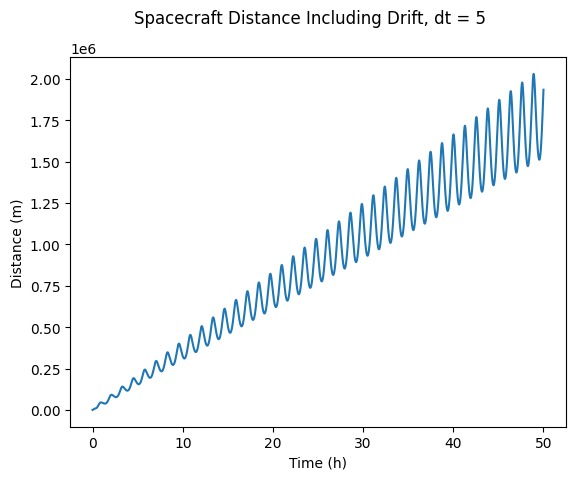

In [185]:
distanceVector = integratedPoint.posArr[:, :]-elementPositions[:, :3]
distance = [np.dot(distanceVector[i], distanceVector[i])**0.5 for i in range(0, segmentCount)]

driftStr = "Including" if includeDrift else "Excluding"

fig = plt.figure()
fig.suptitle(f'Spacecraft Distance {driftStr} Drift, dt = {dt}')
axis = fig.add_subplot()
axis.plot([i*dt/3600 for i in range(0, segmentCount)], distance)
axis.set(xlabel = "Time (h)", ylabel = "Distance (m)")

# plt.plot(orbitalElementsIntegrated[:, num]-orbitalElementsPropogated[:, num])



# plt.plot(orbitalElementsPropogated[:, 0])

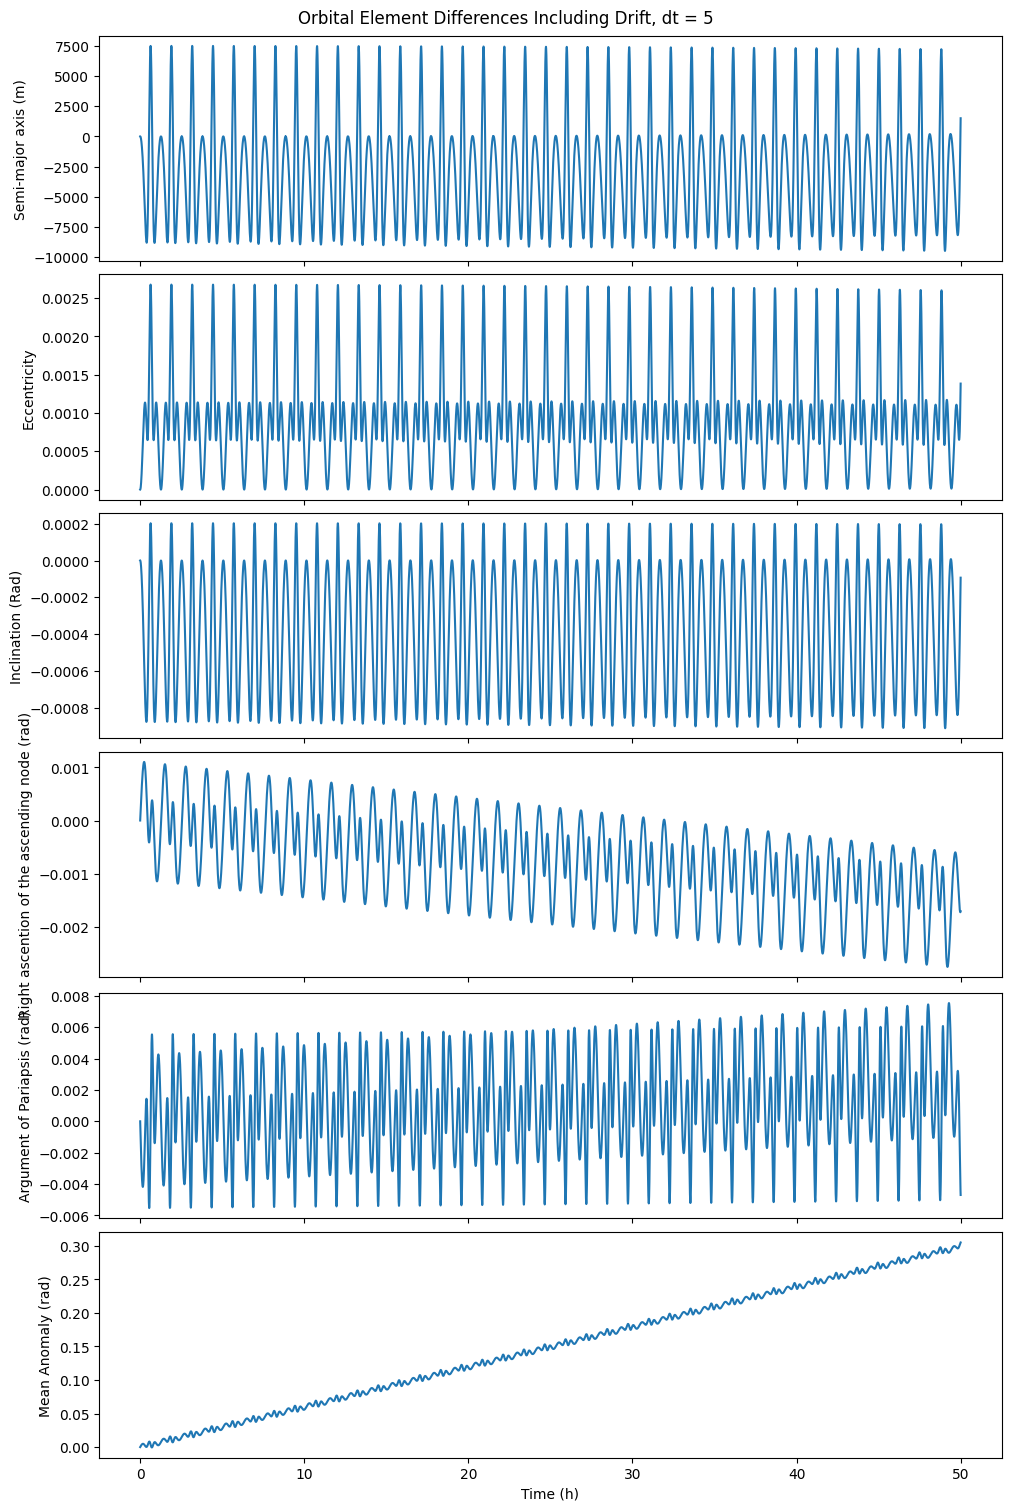

In [186]:
# elements = (a, ecc, inc, RAAN, omega, M0)
# a = Semi-major axis (m)
# ecc = Eccentricity
# inc = Inclination (rad)
# RAAN = Right ascention of the ascending node (rad) also called Longitude of ascending node
# omega = Argument of periapsis (rad)
# M0 = Mean anomaly at t = 0 (radians)
isAngle = [False, False, True, True, True, True]
labels = ["Semi-major axis (m)", "Eccentricity", "Inclination (Rad)", "Right ascention of the ascending node (rad)", "Argument of Pariapsis (rad)", "Mean Anomaly (rad)"]
fig, axs = plt.subplots(len(labels), layout='constrained', sharex=True)
fig.suptitle(f'Orbital Element Differences {driftStr} Drift, dt = {dt}')

for i in range(0, len(labels)):
    if isAngle:
        modifier = [(0 if np.abs(orbitalElementsIntegrated[j, i]-orbitalElementsPropogated[j, i]) < 1.9*np.pi else (-2*np.pi if orbitalElementsIntegrated[j, i]-orbitalElementsPropogated[j, i] > 0 else 2*np.pi)) for j in range(0, len(orbitalElementsIntegrated))]
        axs[i].plot([i*dt/3600 for i in range(0, segmentCount)], (orbitalElementsIntegrated[:, i]-orbitalElementsPropogated[:, i]+modifier))
    else:
        axs[i].plot([i*dt/3600 for i in range(0, segmentCount)], orbitalElementsIntegrated[:, i]-orbitalElementsPropogated[:, i])
    axs[i].set(ylabel=labels[i])

axs[i].set(xlabel = "Time (h)")
fig.set_figwidth(10)
fig.set_figheight(15)


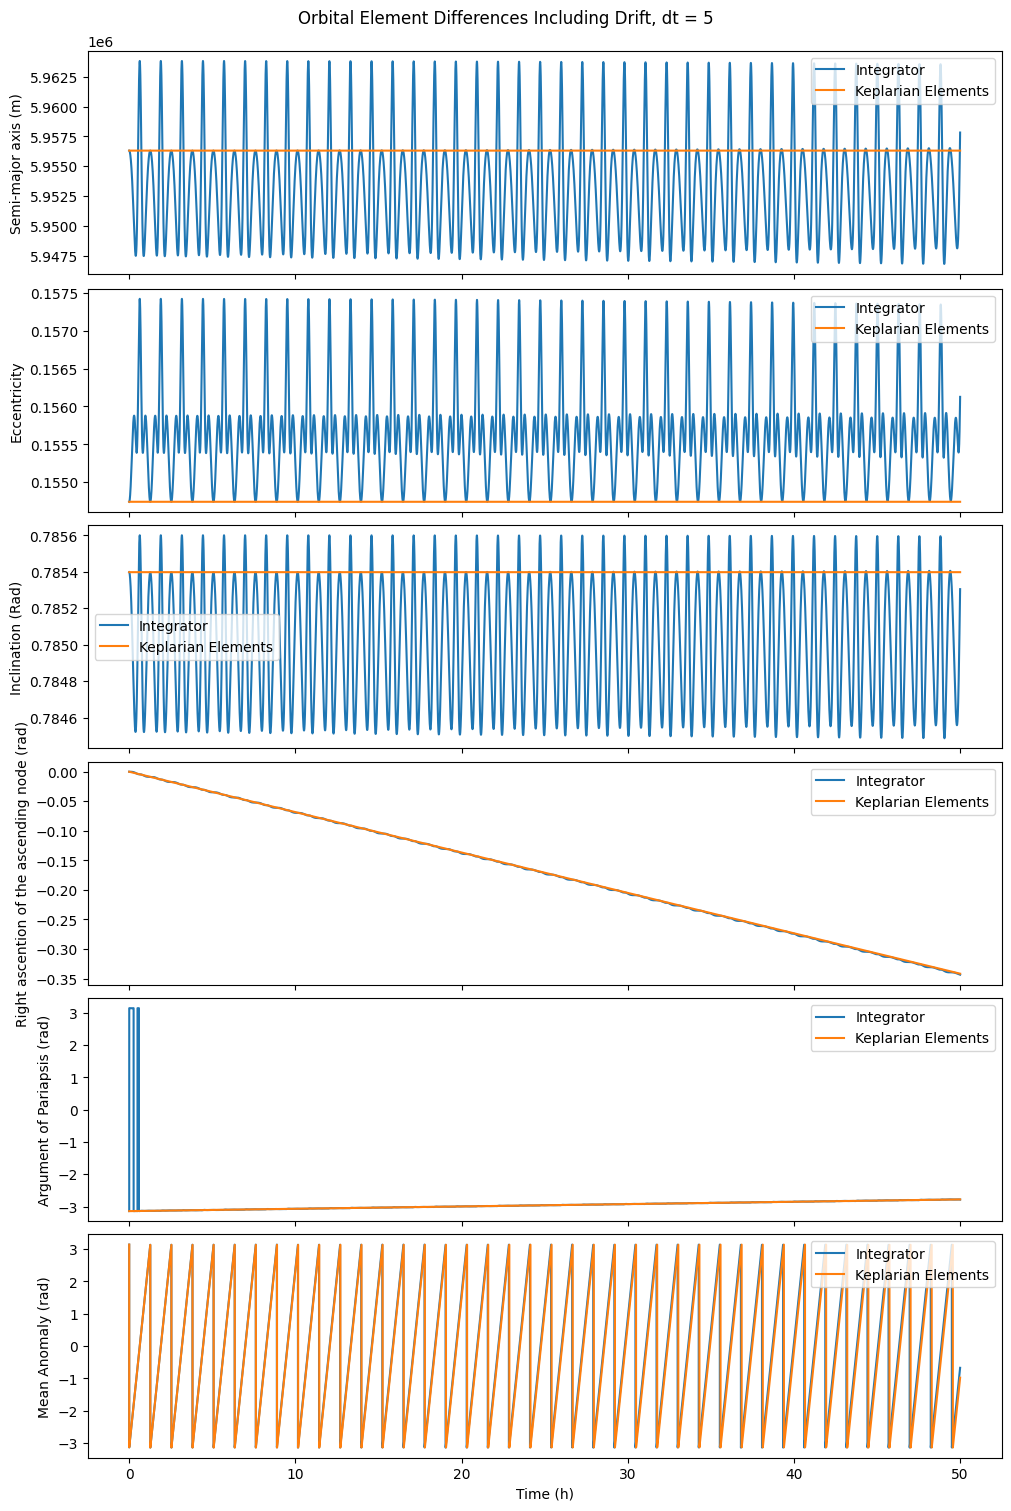

In [187]:
# elements = (a, ecc, inc, RAAN, omega, M0)
# a = Semi-major axis (m)
# ecc = Eccentricity
# inc = Inclination (rad)
# RAAN = Right ascention of the ascending node (rad) also called Longitude of ascending node
# omega = Argument of periapsis (rad)
# M0 = Mean anomaly at t = 0 (radians)
labels = ["Semi-major axis (m)", "Eccentricity", "Inclination (Rad)", "Right ascention of the ascending node (rad)", "Argument of Pariapsis (rad)", "Mean Anomaly (rad)"]
fig, axs = plt.subplots(len(labels), layout='constrained', sharex=True)
fig.suptitle(f'Orbital Element Values {driftStr} Drift, dt = {dt}')

for i in range(0, len(labels)):
    axs[i].plot([i*dt/3600 for i in range(0, segmentCount)], orbitalElementsIntegrated[:, i], label = "Integrator")
    axs[i].plot([i*dt/3600 for i in range(0, segmentCount)], orbitalElementsPropogated[:, i], label = "Keplarian Elements")
    axs[i].legend()
    axs[i].set(ylabel=labels[i])

axs[i].set(xlabel = "Time (h)")
fig.set_figwidth(10)
fig.set_figheight(15)

[Text(0.5, 0, 'GSE x (m)'),
 Text(0.5, 0.5, 'GSE y (m)'),
 Text(0.5, 0, 'GSE z (m)')]

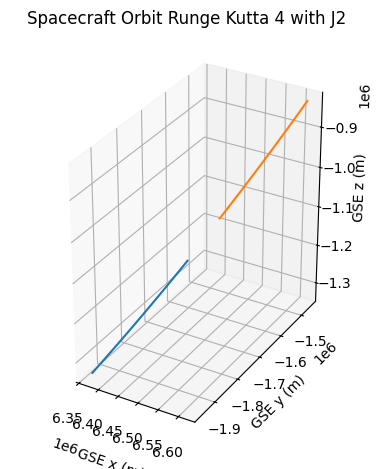

In [188]:
start = 9990
end = 10000
fig = plt.figure()
fig.suptitle('Spacecraft Orbit Runge Kutta 4 with J2')
axis = fig.add_subplot(projection='3d')
axis.plot(elementPositions[start:end, 0], elementPositions[start:end, 1], elementPositions[start:end, 2])
axis.plot(integratedPoint.posArr[start:end, 0], integratedPoint.posArr[start:end, 1], integratedPoint.posArr[start:end, 2])
axis.set_aspect('equal')
axis.set(xlabel = "GSE x (m)", ylabel = "GSE y (m)", zlabel = "GSE z (m)")